In [1]:
# !pip install -U tensorflow>=2.5

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
import cv2
import matplotlib.pyplot as plt
import random

In [4]:
import os
import pathlib

import matplotlib
import matplotlib.pyplot as plt

import io
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from six.moves.urllib.request import urlopen

import tensorflow as tf
import tensorflow_hub as hub

import copy

tf.get_logger().setLevel('ERROR')

In [5]:
# Segmenting the video into frames
def FrameCapture(path):

  frames=[]
  vid=cv2.VideoCapture(path)
  count=0
  success=1
  while success:
    success, image=vid.read()
    frames.append(image)
    count+=1
  return frames


In [30]:
# Improting the video
vid_path="/content/drive/My Drive/HighwayTraffic2.mov"
video_frames=FrameCapture(vid_path)
len(video_frames)

251

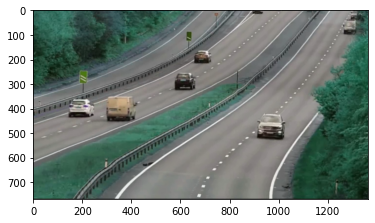

Frame:  96


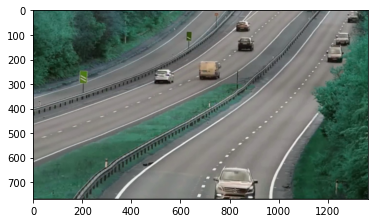

Frame:  160


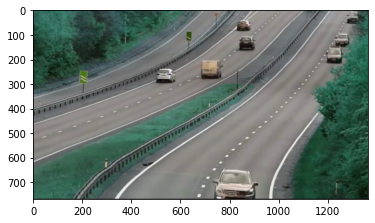

Frame:  161


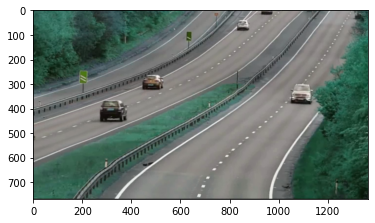

Frame:  49


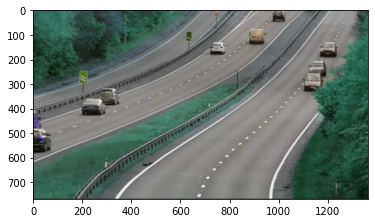

Frame:  220


In [7]:
# Displaying 5 random Frames
for i in range(0,5):
  y=random.randrange(250)
  plt.imshow(video_frames[y])
  plt.show()
  print("Frame: ",y)

In [31]:
# Creating an nd array
video_frames=np.array(video_frames)
video_frames.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


(251,)

In [32]:
vf = copy.deepcopy(video_frames)

In [33]:
# Reshaping the frames to (1, image height, image width, 3)
for i,vv in enumerate(video_frames):
  if vv is None:
    print(vv,i)
    continue
  video_frames[i] = video_frames[i].reshape((1,)+video_frames[i].shape)
  print(video_frames[i].shape)
  # break

(1, 768, 1364, 3)
(1, 768, 1364, 3)
(1, 768, 1364, 3)
(1, 768, 1364, 3)
(1, 768, 1364, 3)
(1, 768, 1364, 3)
(1, 768, 1364, 3)
(1, 768, 1364, 3)
(1, 768, 1364, 3)
(1, 768, 1364, 3)
(1, 768, 1364, 3)
(1, 768, 1364, 3)
(1, 768, 1364, 3)
(1, 768, 1364, 3)
(1, 768, 1364, 3)
(1, 768, 1364, 3)
(1, 768, 1364, 3)
(1, 768, 1364, 3)
(1, 768, 1364, 3)
(1, 768, 1364, 3)
(1, 768, 1364, 3)
(1, 768, 1364, 3)
(1, 768, 1364, 3)
(1, 768, 1364, 3)
(1, 768, 1364, 3)
(1, 768, 1364, 3)
(1, 768, 1364, 3)
(1, 768, 1364, 3)
(1, 768, 1364, 3)
(1, 768, 1364, 3)
(1, 768, 1364, 3)
(1, 768, 1364, 3)
(1, 768, 1364, 3)
(1, 768, 1364, 3)
(1, 768, 1364, 3)
(1, 768, 1364, 3)
(1, 768, 1364, 3)
(1, 768, 1364, 3)
(1, 768, 1364, 3)
(1, 768, 1364, 3)
(1, 768, 1364, 3)
(1, 768, 1364, 3)
(1, 768, 1364, 3)
(1, 768, 1364, 3)
(1, 768, 1364, 3)
(1, 768, 1364, 3)
(1, 768, 1364, 3)
(1, 768, 1364, 3)
(1, 768, 1364, 3)
(1, 768, 1364, 3)
(1, 768, 1364, 3)
(1, 768, 1364, 3)
(1, 768, 1364, 3)
(1, 768, 1364, 3)
(1, 768, 1364, 3)
(1, 768, 1

In [34]:
# Deleting blank frames
video_frames=np.delete(video_frames,250)

In [35]:
# Importing the model
ALL_MODELS = {
'CenterNet HourGlass104 512x512' : 'https://tfhub.dev/tensorflow/centernet/hourglass_512x512/1',
'CenterNet HourGlass104 Keypoints 512x512' : 'https://tfhub.dev/tensorflow/centernet/hourglass_512x512_kpts/1',
'CenterNet HourGlass104 1024x1024' : 'https://tfhub.dev/tensorflow/centernet/hourglass_1024x1024/1',
'CenterNet HourGlass104 Keypoints 1024x1024' : 'https://tfhub.dev/tensorflow/centernet/hourglass_1024x1024_kpts/1',
'CenterNet Resnet50 V1 FPN 512x512' : 'https://tfhub.dev/tensorflow/centernet/resnet50v1_fpn_512x512/1',
'CenterNet Resnet50 V1 FPN Keypoints 512x512' : 'https://tfhub.dev/tensorflow/centernet/resnet50v1_fpn_512x512_kpts/1',
'CenterNet Resnet101 V1 FPN 512x512' : 'https://tfhub.dev/tensorflow/centernet/resnet101v1_fpn_512x512/1',
'CenterNet Resnet50 V2 512x512' : 'https://tfhub.dev/tensorflow/centernet/resnet50v2_512x512/1',
'CenterNet Resnet50 V2 Keypoints 512x512' : 'https://tfhub.dev/tensorflow/centernet/resnet50v2_512x512_kpts/1',
'EfficientDet D0 512x512' : 'https://tfhub.dev/tensorflow/efficientdet/d0/1',
'EfficientDet D1 640x640' : 'https://tfhub.dev/tensorflow/efficientdet/d1/1',
'EfficientDet D2 768x768' : 'https://tfhub.dev/tensorflow/efficientdet/d2/1',
'EfficientDet D3 896x896' : 'https://tfhub.dev/tensorflow/efficientdet/d3/1',
'EfficientDet D4 1024x1024' : 'https://tfhub.dev/tensorflow/efficientdet/d4/1',
'EfficientDet D5 1280x1280' : 'https://tfhub.dev/tensorflow/efficientdet/d5/1',
'EfficientDet D6 1280x1280' : 'https://tfhub.dev/tensorflow/efficientdet/d6/1',
'EfficientDet D7 1536x1536' : 'https://tfhub.dev/tensorflow/efficientdet/d7/1',
'SSD MobileNet v2 320x320' : 'https://tfhub.dev/tensorflow/ssd_mobilenet_v2/2',
'SSD MobileNet V1 FPN 640x640' : 'https://tfhub.dev/tensorflow/ssd_mobilenet_v1/fpn_640x640/1',
'SSD MobileNet V2 FPNLite 320x320' : 'https://tfhub.dev/tensorflow/ssd_mobilenet_v2/fpnlite_320x320/1',
'SSD MobileNet V2 FPNLite 640x640' : 'https://tfhub.dev/tensorflow/ssd_mobilenet_v2/fpnlite_640x640/1',
'SSD ResNet50 V1 FPN 640x640 (RetinaNet50)' : 'https://tfhub.dev/tensorflow/retinanet/resnet50_v1_fpn_640x640/1',
'SSD ResNet50 V1 FPN 1024x1024 (RetinaNet50)' : 'https://tfhub.dev/tensorflow/retinanet/resnet50_v1_fpn_1024x1024/1',
'SSD ResNet101 V1 FPN 640x640 (RetinaNet101)' : 'https://tfhub.dev/tensorflow/retinanet/resnet101_v1_fpn_640x640/1',
'SSD ResNet101 V1 FPN 1024x1024 (RetinaNet101)' : 'https://tfhub.dev/tensorflow/retinanet/resnet101_v1_fpn_1024x1024/1',
'SSD ResNet152 V1 FPN 640x640 (RetinaNet152)' : 'https://tfhub.dev/tensorflow/retinanet/resnet152_v1_fpn_640x640/1',
'SSD ResNet152 V1 FPN 1024x1024 (RetinaNet152)' : 'https://tfhub.dev/tensorflow/retinanet/resnet152_v1_fpn_1024x1024/1',
'Faster R-CNN ResNet50 V1 640x640' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet50_v1_640x640/1',
'Faster R-CNN ResNet50 V1 1024x1024' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet50_v1_1024x1024/1',
'Faster R-CNN ResNet50 V1 800x1333' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet50_v1_800x1333/1',
'Faster R-CNN ResNet101 V1 640x640' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet101_v1_640x640/1',
'Faster R-CNN ResNet101 V1 1024x1024' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet101_v1_1024x1024/1',
'Faster R-CNN ResNet101 V1 800x1333' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet101_v1_800x1333/1',
'Faster R-CNN ResNet152 V1 640x640' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet152_v1_640x640/1',
'Faster R-CNN ResNet152 V1 1024x1024' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet152_v1_1024x1024/1',
'Faster R-CNN ResNet152 V1 800x1333' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet152_v1_800x1333/1',
'Faster R-CNN Inception ResNet V2 640x640' : 'https://tfhub.dev/tensorflow/faster_rcnn/inception_resnet_v2_640x640/1',
'Faster R-CNN Inception ResNet V2 1024x1024' : 'https://tfhub.dev/tensorflow/faster_rcnn/inception_resnet_v2_1024x1024/1',
'Mask R-CNN Inception ResNet V2 1024x1024' : 'https://tfhub.dev/tensorflow/mask_rcnn/inception_resnet_v2_1024x1024/1'
}

IMAGES_FOR_TEST = {
  'Beach' : 'models/research/object_detection/test_images/image2.jpg',
  'Dogs' : 'models/research/object_detection/test_images/image1.jpg',
  # By Heiko Gorski, Source: https://commons.wikimedia.org/wiki/File:Naxos_Taverna.jpg
  'Naxos Taverna' : 'https://upload.wikimedia.org/wikipedia/commons/6/60/Naxos_Taverna.jpg',
  # Source: https://commons.wikimedia.org/wiki/File:The_Coleoptera_of_the_British_islands_(Plate_125)_(8592917784).jpg
  'Beatles' : 'https://upload.wikimedia.org/wikipedia/commons/1/1b/The_Coleoptera_of_the_British_islands_%28Plate_125%29_%288592917784%29.jpg',
  # By Américo Toledano, Source: https://commons.wikimedia.org/wiki/File:Biblioteca_Maim%C3%B3nides,_Campus_Universitario_de_Rabanales_007.jpg
  'Phones' : 'https://upload.wikimedia.org/wikipedia/commons/thumb/0/0d/Biblioteca_Maim%C3%B3nides%2C_Campus_Universitario_de_Rabanales_007.jpg/1024px-Biblioteca_Maim%C3%B3nides%2C_Campus_Universitario_de_Rabanales_007.jpg',
  # Source: https://commons.wikimedia.org/wiki/File:The_smaller_British_birds_(8053836633).jpg
  'Birds' : 'https://upload.wikimedia.org/wikipedia/commons/0/09/The_smaller_British_birds_%288053836633%29.jpg',
  # Source: https://upload.wikimedia.org/wikipedia/commons/7/72/GB_London_Street_View_12.jpg
  'Street' : 'https://upload.wikimedia.org/wikipedia/commons/7/72/GB_London_Street_View_12.jpg',
}

COCO17_HUMAN_POSE_KEYPOINTS = [(0, 1),
 (0, 2),
 (1, 3),
 (2, 4),
 (0, 5),
 (0, 6),
 (5, 7),
 (7, 9),
 (6, 8),
 (8, 10),
 (5, 6),
 (5, 11),
 (6, 12),
 (11, 12),
 (11, 13),
 (13, 15),
 (12, 14),
 (14, 16)]

In [36]:
# Clone the tensorflow models repository
!git clone --depth 1 https://github.com/tensorflow/models

fatal: destination path 'models' already exists and is not an empty directory.


In [14]:
%%bash
sudo apt install -y protobuf-compiler
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .


Reading package lists...
Building dependency tree...
Reading state information...
protobuf-compiler is already the newest version (3.0.0-9.1ubuntu1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /content/models/research
  Created wheel for object-detection: filename=object_detection-0.1-py3-none-any.whl size=1696118 sha256=3ba1d3097d6a323ab2417c1cf75c3e6298ae750af8df9185f3c3cd46b71eefcb
  Stored in directory: /tmp/pip-ephem-wheel-cache-6qi5aexw/wheels/fa/a4/d2/e9a5057e414fd46c8e543d2706cd836d64e1fcd9eccceb2329
  Created wheel for py-cpuinfo: filename=py_cpuinfo-8.0.0-py3-none-any.whl size=22257 sha256=aecb30529216d5d97dd7eb6845140f3a693c2a3d37addac3fc6cdcbe1f5a87a1
  Stored in directory: /root/.cache/pip/wheels/d2/f1/1f/0



  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.


In [15]:
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import ops as utils_ops

%matplotlib inline

In [16]:
PATH_TO_LABELS = './models/research/object_detection/data/mscoco_label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

In [18]:
#@title Model Selection { display-mode: "form", run: "auto" }
model_display_name = 'Faster R-CNN ResNet50 V1 1024x1024' # @param ['CenterNet HourGlass104 512x512','CenterNet HourGlass104 Keypoints 512x512','CenterNet HourGlass104 1024x1024','CenterNet HourGlass104 Keypoints 1024x1024','CenterNet Resnet50 V1 FPN 512x512','CenterNet Resnet50 V1 FPN Keypoints 512x512','CenterNet Resnet101 V1 FPN 512x512','CenterNet Resnet50 V2 512x512','CenterNet Resnet50 V2 Keypoints 512x512','EfficientDet D0 512x512','EfficientDet D1 640x640','EfficientDet D2 768x768','EfficientDet D3 896x896','EfficientDet D4 1024x1024','EfficientDet D5 1280x1280','EfficientDet D6 1280x1280','EfficientDet D7 1536x1536','SSD MobileNet v2 320x320','SSD MobileNet V1 FPN 640x640','SSD MobileNet V2 FPNLite 320x320','SSD MobileNet V2 FPNLite 640x640','SSD ResNet50 V1 FPN 640x640 (RetinaNet50)','SSD ResNet50 V1 FPN 1024x1024 (RetinaNet50)','SSD ResNet101 V1 FPN 640x640 (RetinaNet101)','SSD ResNet101 V1 FPN 1024x1024 (RetinaNet101)','SSD ResNet152 V1 FPN 640x640 (RetinaNet152)','SSD ResNet152 V1 FPN 1024x1024 (RetinaNet152)','Faster R-CNN ResNet50 V1 640x640','Faster R-CNN ResNet50 V1 1024x1024','Faster R-CNN ResNet50 V1 800x1333','Faster R-CNN ResNet101 V1 640x640','Faster R-CNN ResNet101 V1 1024x1024','Faster R-CNN ResNet101 V1 800x1333','Faster R-CNN ResNet152 V1 640x640','Faster R-CNN ResNet152 V1 1024x1024','Faster R-CNN ResNet152 V1 800x1333','Faster R-CNN Inception ResNet V2 640x640','Faster R-CNN Inception ResNet V2 1024x1024','Mask R-CNN Inception ResNet V2 1024x1024']
model_handle = ALL_MODELS[model_display_name]

print('Selected model:'+ model_display_name)
print('Model Handle at TensorFlow Hub: {}'.format(model_handle))

Selected model:Faster R-CNN ResNet50 V1 1024x1024
Model Handle at TensorFlow Hub: https://tfhub.dev/tensorflow/faster_rcnn/resnet50_v1_1024x1024/1


In [19]:
print('loading model...')
hub_model = hub.load(model_handle)
print('model loaded!')

loading model...
model loaded!


Feeding each frame into the model and saving the results to a list

In [24]:
output_frames=[]
for i in range(0,250):
  x=video_frames[i]
  results=hub_model(x)
  result = {key:value.numpy() for key,value in results.items()}
  print(result.keys())
  label_id_offset = 0
  image_np_with_detections = x.copy()
  # Use keypoints if available in detections
  keypoints, keypoint_scores = None, None
  if 'detection_keypoints' in result:
    keypoints = result['detection_keypoints'][0]
    keypoint_scores = result['detection_keypoint_scores'][0]
  image=viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_detections[0],
        result['detection_boxes'][0],
        (result['detection_classes'][0] + label_id_offset).astype(int),
        result['detection_scores'][0],
        category_index,
        use_normalized_coordinates=True,
        max_boxes_to_draw=200,
        min_score_thresh=.30,
        agnostic_mode=False,
        keypoints=keypoints,
        keypoint_scores=keypoint_scores,
        keypoint_edges=COCO17_HUMAN_POSE_KEYPOINTS)
  output_frames.append(image)

dict_keys(['detection_boxes', 'detection_multiclass_scores', 'raw_detection_boxes', 'raw_detection_scores', 'num_detections', 'detection_classes', 'detection_scores', 'detection_anchor_indices'])
dict_keys(['detection_boxes', 'detection_multiclass_scores', 'raw_detection_boxes', 'raw_detection_scores', 'num_detections', 'detection_classes', 'detection_scores', 'detection_anchor_indices'])
dict_keys(['detection_boxes', 'detection_multiclass_scores', 'raw_detection_boxes', 'raw_detection_scores', 'num_detections', 'detection_classes', 'detection_scores', 'detection_anchor_indices'])
dict_keys(['detection_boxes', 'detection_multiclass_scores', 'raw_detection_boxes', 'raw_detection_scores', 'num_detections', 'detection_classes', 'detection_scores', 'detection_anchor_indices'])
dict_keys(['detection_boxes', 'detection_multiclass_scores', 'raw_detection_boxes', 'raw_detection_scores', 'num_detections', 'detection_classes', 'detection_scores', 'detection_anchor_indices'])
dict_keys(['detectio

In [25]:
len(output_frames)

250

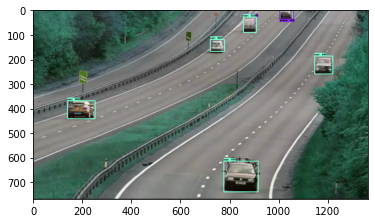

In [26]:
plt.imshow(output_frames[0])

Creating the video

In [27]:
import cv2

# setting the frame width, height width
# the width, height of first image
height, width, layers = 768, 1364, 3

video = cv2.VideoWriter("object_detection_video.mp4",cv2.VideoWriter_fourcc(*'DIVX'), 30, (width, height)) 
for i in output_frames:
  video.write(i)
  
video.release() 